In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path

In [5]:
#@title Set Paths
base_dir = os.getenv('BASE_DIR')
if not base_dir:
    raise ValueError("BASE_DIR environment variable is not set.")

In [ ]:
# Select country
COUNTRY = 'indonesia'

### Store raw files lists
We use this to calculate statistics, e.g get total count of days per site

In [17]:
# Folder containing audio files
audio_dir = Path("/media/mars_5tb_drive/mars_global_acoustic_study/" + COUNTRY + "_acoustics/raw_audio")

# Output CSV path
raw_file_list = os.path.join(base_dir, "marrs_acoustics/data/output_dir_" + COUNTRY + "/raw_file_list.csv")

# Collect all .wav and .WAV files
file_list = [f for f in os.listdir(audio_dir) if f.lower().endswith('.wav')]

# Save the list to a CSV file
file_list_df = pd.DataFrame(file_list, columns=["filename"])
file_list_df.to_csv(raw_file_list, index=False)

print(f"File list saved to {raw_file_list}")


File list saved to /home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_indonesia/raw_file_list.csv


### Calculate total recording time on each site
Note, each recorder was on a duty cycle of one in two min. So if a recorder has a total of 10 days, that means it collected 10 days of total audio across a 20 day period.

In [24]:
# Extract the 'site name' from the filename (15th and 16th characters)
file_list_df['site_name'] = file_list_df['filename'].str[4:6]

# Count the number of files (minutes of audio) per site
minutes_per_site = file_list_df['site_name'].value_counts().sort_index()

# Convert minutes to days (1440 minutes in a day)
days_per_site = minutes_per_site / 1440

# Convert to DataFrames for full display in Jupyter
minutes_per_site_df = minutes_per_site.reset_index(name="Minutes")
days_per_site_df = days_per_site.reset_index(name="Days")

# Display in list format in Jupyter
print("Minutes of audio per site:")
display(minutes_per_site_df)

print("\nDays of audio per site:")
display(days_per_site_df)


Minutes of audio per site:


,site_name,Minutes
0,D1,15575
1,D2,15138
2,D3,15229
3,D4,15049
4,D5,17578
5,D6,15045
6,H1,15960
7,H2,15628
8,H3,16377
9,H4,3270



Days of audio per site:


,site_name,Days
0,D1,10.815972
1,D2,10.512500
2,D3,10.575694
3,D4,10.450694
4,D5,12.206944
5,D6,10.447917
6,H1,11.083333
7,H2,10.852778
8,H3,11.372917
9,H4,2.270833


### Plot individual sounds
Will plot the mean count per day of 5sec periods that contain the target sound.
As the recorders were on a duty cycle of one in two minutes, we double all counts.

Start by prepping a df

In [45]:
# Set target sound and the duty cycle
TARGET_SOUND = 'rattle'
DUTY_CYCLE = 2

/tmp/ipykernel_222898/889588202.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['site_name'] = filtered_df['filename'].str[14:16]


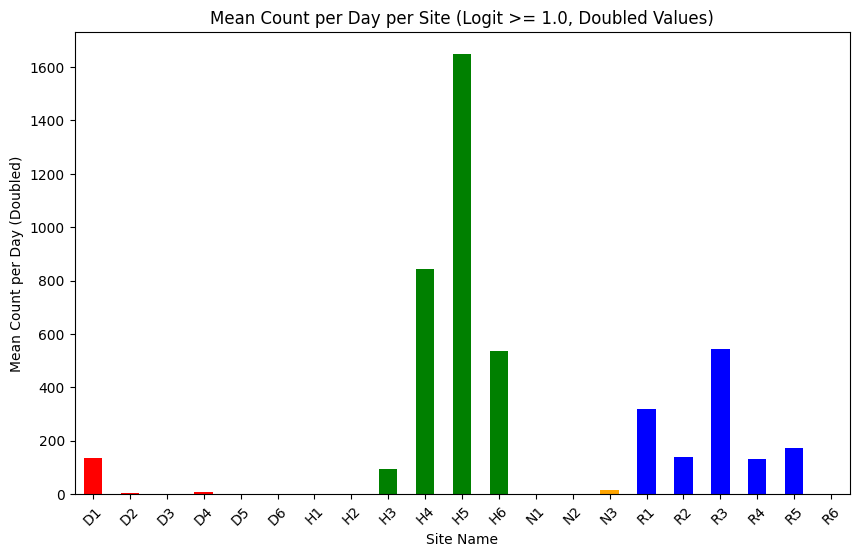

In [46]:
# Load the CSV file
inference_csv = os.path.join(base_dir, f'marrs_acoustics/data/output_dir_{COUNTRY}/agile_outputs/{TARGET_SOUND}/{TARGET_SOUND}_inference.csv')
inference_df = pd.read_csv(inference_csv)

# Remove leading and trailing spaces from column names
inference_df.columns = inference_df.columns.str.strip()

# Filter rows where 'logit' is 1.0 or higher
filtered_df = inference_df[inference_df['logit'] >= 1.0]

# Extract 'site name' from the 'filename' column (15th and 16th characters)
filtered_df['site_name'] = filtered_df['filename'].str[14:16]

# Count occurrences of each site and sort by site name alphabetically
site_counts = filtered_df['site_name'].value_counts().sort_index()

# Get days of audio per site (from previous code)
days_per_site = minutes_per_site / 1440

# Calculate mean count per day for each site
mean_count_per_day = site_counts / days_per_site

# Double the values for each bar to visualise a higher scale
mean_count_per_day *= DUTY_CYCLE  # Doubling each value as requested

# Define colours based on the starting letter of each site name
colours = mean_count_per_day.index.map(lambda site: 
    'red' if site.startswith('D') else
    'green' if site.startswith('H') else
    'orange' if site.startswith('N') else
    'blue' if site.startswith('R') else 'grey'  # Default to grey if none of the specified letters match
)

# Plotting
plt.figure(figsize=(10, 6))
mean_count_per_day.plot(kind='bar', color=colours)
plt.title("Mean Count per Day per Site (Logit >= 1.0, Doubled Values)")
plt.xlabel("Site Name")
plt.ylabel("Mean Count per Day (Doubled)")
plt.xticks(rotation=45)

# Define the save path and create directories if they do not exist
save_dir = os.path.join(base_dir, 'marrs_acoustics/data/results/' + COUNTRY + '/barplots')
os.makedirs(save_dir, exist_ok=True) 

# Save the plot
save_path = os.path.join(save_dir, f"{TARGET_SOUND}.png")
plt.savefig(save_path)

plt.show()


TODO: 
1. get actual sunrise and sunset times, currently uses 6am and 6pm
2. Plot all sites
3. use the raw file list csv to set time bound
4. use or merge colour codes in cell above
5. tidy up axis etc

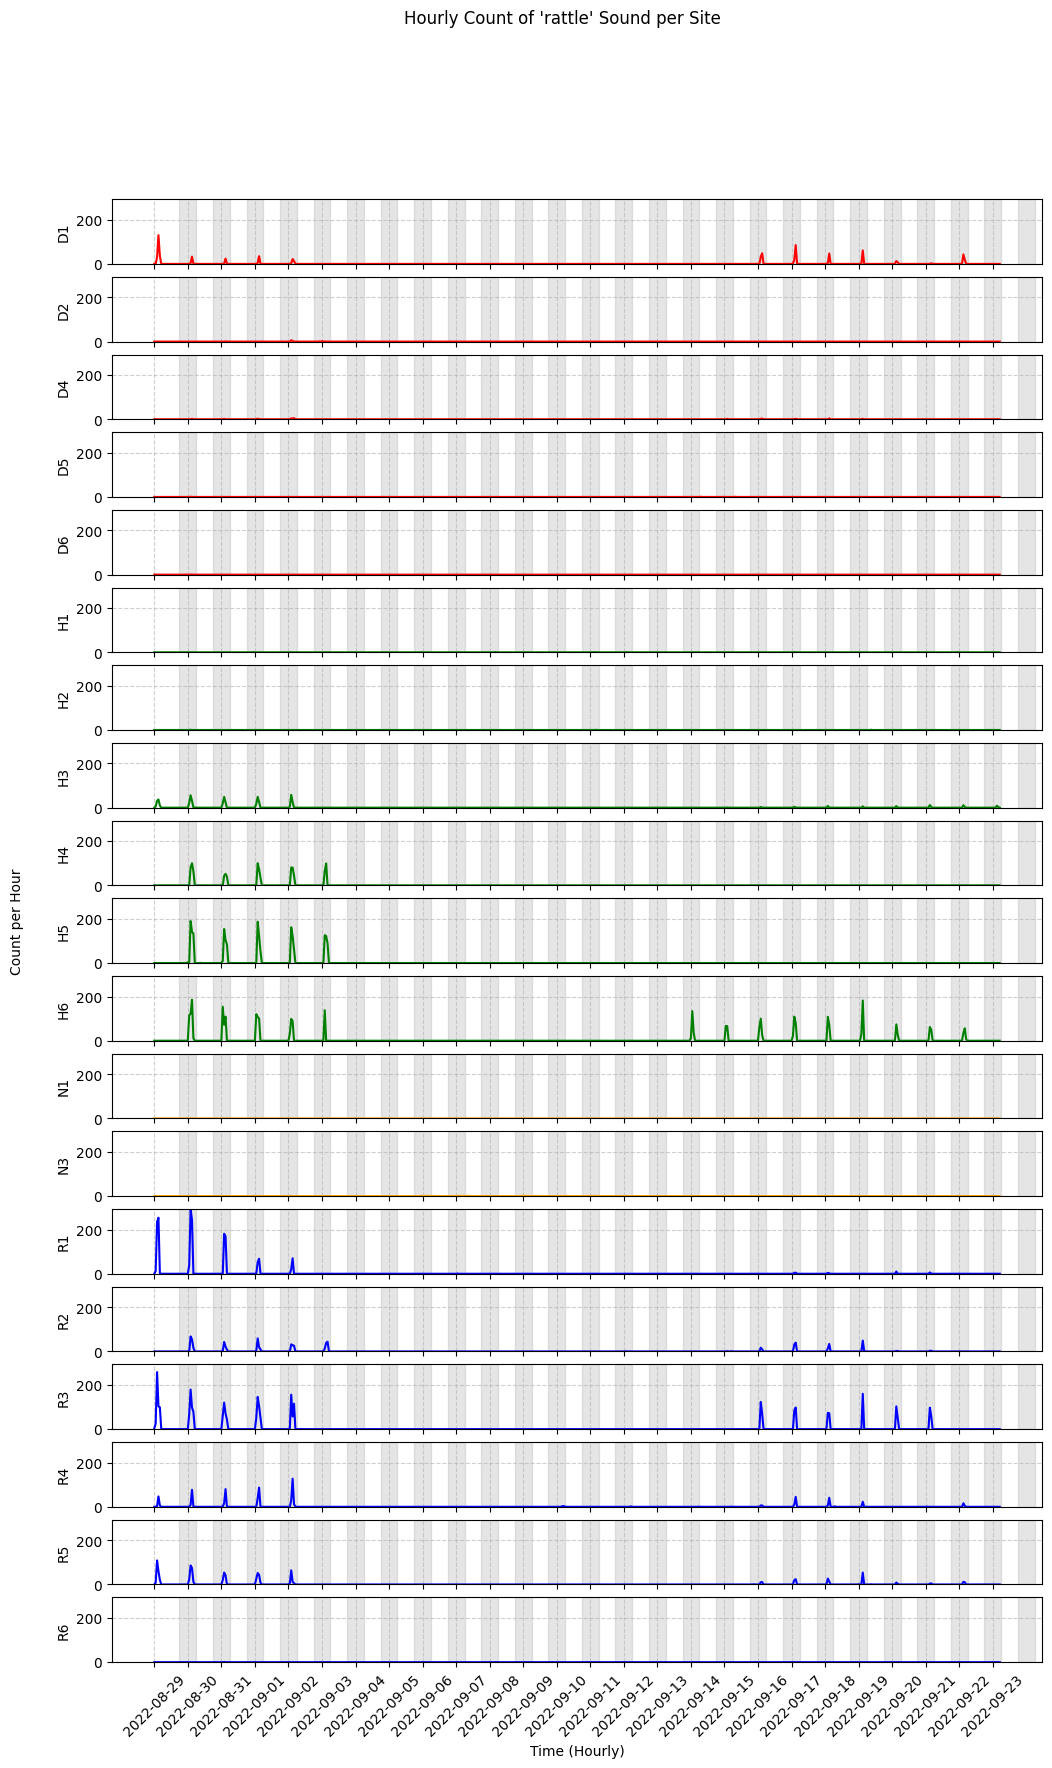

In [61]:
from datetime import datetime, timedelta

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Extract 'site_name', 'date', and 'time' from 'filename'
filtered_df['site_name'] = filtered_df['filename'].str[14:16]
filtered_df['date'] = filtered_df['filename'].str[17:25]  # Characters 18-25 for the date
filtered_df['time'] = filtered_df['filename'].str[26:32]  # Characters 27-32 for the time

# Convert 'date' and 'time' to datetime and extract hour
filtered_df['datetime'] = pd.to_datetime(filtered_df['date'] + filtered_df['time'], format='%Y%m%d%H%M%S')
filtered_df['hour'] = filtered_df['datetime'].dt.floor('H')  # Floor to the nearest hour

# Group by 'site_name' and 'hour' to get the count of occurrences per hour
hourly_counts = filtered_df.groupby(['site_name', 'hour']).size().reset_index(name='count')

# Find the earliest and latest datetime for consistent x-axis range
start_time = filtered_df['datetime'].min().floor('H')
end_time = filtered_df['datetime'].max().ceil('H')

# Generate a timeline covering the entire range, at hourly intervals
all_hours = pd.date_range(start=start_time, end=end_time, freq='H')

# Prepare an empty dataframe with all hours and sites to ensure no gaps in the timeline
timeline_df = pd.DataFrame([(site, hour) for site in hourly_counts['site_name'].unique() for hour in all_hours], columns=['site_name', 'hour'])

# Merge with the actual counts to fill missing hours with zero counts
timeline_df = timeline_df.merge(hourly_counts, on=['site_name', 'hour'], how='left').fillna(0)

# Define a fixed colour mapping for each site prefix
colour_mapping = {
    'D': 'red',
    'H': 'green',
    'N': 'orange',
    'R': 'blue'
}

# Get unique sites for plotting
sites = sorted(timeline_df['site_name'].unique())

# Find the maximum count across all sites and hours for a common y-axis limit
max_count = timeline_df['count'].max()

# Plotting
fig, axs = plt.subplots(len(sites), 1, figsize=(12, 1 * len(sites)), sharex=True)

for i, site in enumerate(sites):
    # Filter data for the current site
    site_data = timeline_df[timeline_df['site_name'] == site]
    # Determine colour based on the first letter of the site name
    site_colour = colour_mapping.get(site[0], 'grey')
    
    # Plot each site's data in its own subplot
    axs[i].plot(site_data['hour'], site_data['count'], color=site_colour)
    axs[i].set_ylabel(site)
    axs[i].set_ylim(0, max_count)  # Use the common y-axis limit
    axs[i].grid(True, linestyle='--', alpha=0.6)

    # Add shading for night (6 PM to 6 AM)
    for hour in pd.date_range(start=start_time, end=end_time, freq='24H'):
        axs[i].axvspan(hour + timedelta(hours=18), hour + timedelta(days=1, hours=6), color='grey', alpha=0.2)

# Set custom x-tick interval, e.g., every 6 hours
plt.xticks(pd.date_range(start=start_time, end=end_time, freq='24H'), rotation=45)

# Set common labels and titles
plt.suptitle(f"Hourly Count of '{TARGET_SOUND}' Sound per Site")
plt.xlabel("Time (Hourly)")
fig.text(0.04, 0.5, 'Count per Hour', va='center', rotation='vertical')

plt.show()

